### Problem Description

While your data companions rushed off to jobs in finance and government, you remained adamant that science was the way for you. Staying true to your mission, you've since joined Pymaceuticals Inc., a burgeoning pharmaceutical company based out of San Diego, CA. Pymaceuticals specializes in drug-based, anti-cancer pharmaceuticals. In their most recent efforts, they've since begun screening for potential treatments to squamous cell carcinoma (SCC), a commonly occurring form of skin cancer.

As their Chief Data Analyst, you've been given access to the complete data from their most recent animal study. In this study, 250 mice were treated through a variety of drug regimes over the course of 45 days. Their physiological responses were then monitored over the course of that time. Your objective is to analyze the data to show how four treatments (Capomulin, Infubinol, Ketapril, and Placebo) compare.

In [314]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load  
path_mouse_drug = os.path.join('data','mouse_drug_data.csv')
path_clinicaltrial = os.path.join('data','clinicaltrial_data.csv')

# Read the Mouse & Drug Data and the Clinical Trial Data
mouse_drug_df = pd.read_csv(path_mouse_drug)
clinicaltrial_df = pd.read_csv(path_clinicaltrial)

# Combine the data into a single dataset
mouse_drug_clinicaltrial_df = pd.merge(clinicaltrial_df, mouse_drug_df, on='Mouse ID', how='left') \
                                .set_index('Drug') 

# Display the data table for preview
mouse_drug_clinicaltrial_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
Drug,,,,
Capomulin,b128,0,45.0,0
Ketapril,f932,0,45.0,0
Ketapril,g107,0,45.0,0
Ketapril,a457,0,45.0,0
Ketapril,c819,0,45.0,0


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.0,0,Capomulin
1,f932,0,45.0,0,Ketapril
2,g107,0,45.0,0,Ketapril
3,a457,0,45.0,0,Ketapril
4,c819,0,45.0,0,Ketapril


## Tumor Response to Treatment

In [556]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
# Convert to DataFrame # Preview DataFrame

tumor_response_df = pd.DataFrame(mouse_drug_clinicaltrial_df.groupby(['Drug', 'Timepoint'])['Tumor Volume (mm3)'].mean()) \
                        .reset_index()
tumor_response_df.head()


,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.266086
2,Capomulin,10,43.084291
3,Capomulin,15,42.064317
4,Capomulin,20,40.716325


,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.266086
2,Capomulin,10,43.084291
3,Capomulin,15,42.064317
4,Capomulin,20,40.716325
5,Capomulin,25,39.939528
6,Capomulin,30,38.769339
7,Capomulin,35,37.816839
8,Capomulin,40,36.958001
9,Capomulin,45,36.236114


In [557]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint
# Convert to DataFrame # Preview DataFrame

std_error_tumor_df = pd.DataFrame(mouse_drug_clinicaltrial_df.groupby(['Drug', 'Timepoint'])['Tumor Volume (mm3)'].sem()) \
                        .reset_index()
std_error_tumor_df.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


In [558]:
# Minor Data Munging to Re-Format the Data Frames
# Preview that Reformatting worked

tumor_response_df = tumor_response_df.pivot(index='Timepoint', columns='Drug', values='Tumor Volume (mm3)')
tumor_response_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,44.266086,46.503051,47.062001,47.389175,46.796098,47.125589,47.248967,43.944859,47.527452,46.851818
10,43.084291,48.285125,49.403909,49.582269,48.694210,49.423329,49.101541,42.531957,49.463844,48.689881
15,42.064317,50.094055,51.296397,52.399974,50.933018,51.359742,51.067318,41.495061,51.529409,50.779059
20,40.716325,52.157049,53.197691,54.920935,53.644087,54.364417,53.346737,40.238325,54.067395,53.170334


In [559]:
# Minor Data Munging to Re-Format the Data Frames
# Preview that Reformatting worked

std_error_tumor_df = std_error_tumor_df.pivot(index='Timepoint', columns='Drug', values='Tumor Volume (mm3)')
std_error_tumor_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.448593,0.164505,0.235102,0.264819,0.202385,0.218091,0.231708,0.482955,0.239862,0.188950
10,0.702684,0.236144,0.282346,0.357421,0.319415,0.402064,0.376195,0.720225,0.433678,0.263949
15,0.838617,0.332053,0.357705,0.580268,0.444378,0.614461,0.466109,0.770432,0.493261,0.370544
20,0.909731,0.359482,0.476210,0.726484,0.595260,0.839609,0.555181,0.786199,0.621889,0.533182


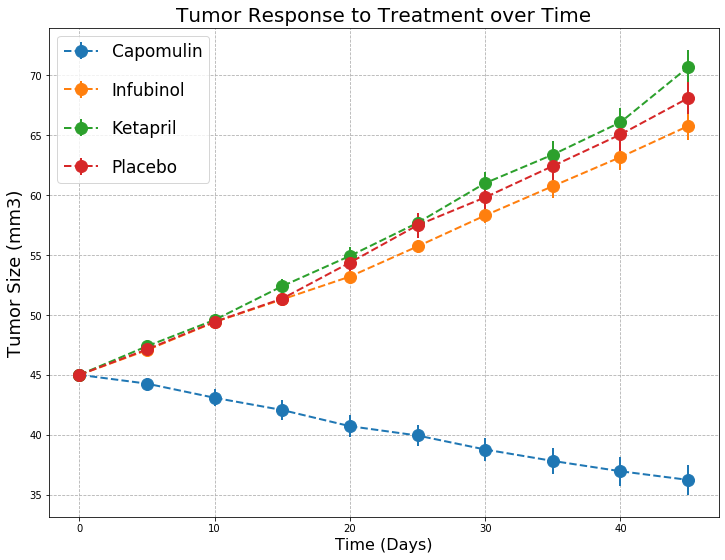

In [566]:
# Generate the Plot (with Error Bars) # Save the Figure

plt.figure(figsize=(12,9))
plt.xlabel('Time (Days)', fontsize=16)
plt.ylabel('Tumor Size (mm3)', fontsize=18)
plt.title('Tumor Response to Treatment over Time', fontsize=20)
plt.grid(linestyle='--')


for drug in tumor_response_df[['Capomulin', 'Infubinol', 'Ketapril', 'Placebo']]:
    plot = plt.errorbar(x=tumor_response_df.index, y=tumor_response_df[drug], yerr=std_error_tumor_df[drug],
                        fmt='o', markersize = 12, linestyle='--', linewidth=2, label=drug)

plt.legend(loc='upper left', labelspacing = 1.2, fontsize = 17)
plt.savefig('Tumor Response.png')
plt.show()

## Metastatic Response to Treatment

In [571]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 
# Convert to DataFrame # Preview DataFrame

metastatic_response_df = mouse_drug_clinicaltrial_df.groupby(['Drug','Timepoint'])['Metastatic Sites'].mean().to_frame()
metastatic_response_df.head()

Metastatic Sites
Drug      Timepoint                  
Capomulin 0                  0.000000
          5                  0.160000
          10                 0.320000
          15                 0.375000
          20                 0.652174

Metastatic Sites
Drug      Timepoint                  
Capomulin 0                  0.000000
          5                  0.160000
          10                 0.320000
          15                 0.375000
          20                 0.652174

In [572]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 
# Convert to DataFrame # Preview DataFrame

metastatic_error_df = mouse_drug_clinicaltrial_df.groupby(['Drug','Timepoint'])['Metastatic Sites'].sem().to_frame()
metastatic_error_df.head()

Metastatic Sites
Drug      Timepoint                  
Capomulin 0                  0.000000
          5                  0.074833
          10                 0.125433
          15                 0.132048
          20                 0.161621

Metastatic Sites
Drug      Timepoint                  
Capomulin 0                  0.000000
          5                  0.074833
          10                 0.125433
          15                 0.132048
          20                 0.161621

In [573]:
# Minor Data Munging to Re-Format the Data Frames # Preview that Reformatting worked

metastatic_response_df = metastatic_response_df.reset_index().pivot(index='Timepoint', columns='Drug', values='Metastatic Sites')
metastatic_response_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.380952,0.280000,0.304348,0.260870,0.375000,0.320000,0.120000,0.240000,0.166667
10,0.320000,0.600000,0.666667,0.590909,0.523810,0.833333,0.565217,0.250000,0.478261,0.500000
15,0.375000,0.789474,0.904762,0.842105,0.857143,1.250000,0.764706,0.333333,0.782609,0.809524
20,0.652174,1.111111,1.050000,1.210526,1.150000,1.526316,1.000000,0.347826,0.952381,1.294118


In [574]:
# Minor Data Munging to Re-Format the Data Frames # Preview that Reformatting worked

metastatic_error_df = metastatic_error_df.reset_index().pivot(index='Timepoint', columns='Drug', values='Metastatic Sites')
metastatic_error_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.074833,0.108588,0.091652,0.098100,0.093618,0.100947,0.095219,0.066332,0.087178,0.077709
10,0.125433,0.152177,0.159364,0.142018,0.163577,0.115261,0.105690,0.090289,0.123672,0.109109
15,0.132048,0.180625,0.194015,0.191381,0.158651,0.190221,0.136377,0.115261,0.153439,0.111677
20,0.161621,0.241034,0.234801,0.236680,0.181731,0.234064,0.171499,0.119430,0.200905,0.166378


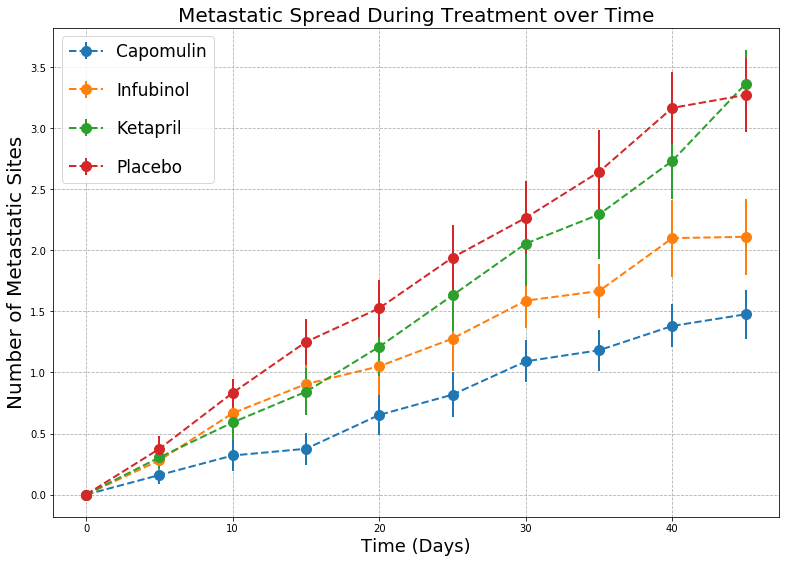

In [576]:
# Generate the Plot (with Error Bars) # Save the Figure # Show the Figure

plt.figure(figsize=(13,9))
plt.xlabel('Time (Days)', fontsize=18)
plt.ylabel('Number of Metastatic Sites', fontsize=20)
plt.title('Metastatic Spread During Treatment over Time', fontsize=20)
plt.grid(linestyle='--')

for drug in metastatic_response_df[['Capomulin', 'Infubinol', 'Ketapril', 'Placebo']]:
    plot = plt.errorbar(x=metastatic_response_df.index, y=metastatic_response_df[drug], yerr=metastatic_error_df[drug], fmt='o', markersize=10, linestyle='--', linewidth=2, label=drug)
    
plt.legend(loc='upper left', labelspacing = 1.2, fontsize = 17)
plt.show()


## Survival Rates

In [578]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
# Convert to DataFrame # Preview DataFrame

mouse_drug_clinicaltrial_df.head()
mouse_count_df = mouse_drug_clinicaltrial_df.groupby(['Drug', 'Timepoint'])['Mouse ID'].count() \
                                            .to_frame() \
                                            .rename(columns={'Mouse ID': 'Mouse Count'}) \
                                            .reset_index()

mouse_count_df = mouse_count_df.assign(percent_survived=[(item/25)*100 for item in mouse_count_df['Mouse Count'].values]) \
                                .rename(columns={'percent_survived':'Percent Survived'})
mouse_count_df.head()

,Drug,Timepoint,Mouse Count,Percent Survived
0,Capomulin,0,25,100.0
1,Capomulin,5,25,100.0
2,Capomulin,10,25,100.0
3,Capomulin,15,24,96.0
4,Capomulin,20,23,92.0


,Drug,Timepoint,Mouse Count
0,Capomulin,0,25
1,Capomulin,5,25
2,Capomulin,10,25
3,Capomulin,15,24
4,Capomulin,20,23


In [580]:
# Minor Data Munging to Re-Format the Data Frames # Preview the Data Frame

mouse_count_df = mouse_count_df.pivot(index='Timepoint', columns='Drug', values='Mouse Count')
mouse_count_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,26,25,26,25
5,25,21,25,23,23,24,25,25,25,24
10,25,20,21,22,21,24,23,24,23,22
15,24,19,21,19,21,20,17,24,23,21
20,23,18,20,19,20,19,17,23,21,17


In [579]:
# Minor Data Munging to Re-Format the Data Frames # Preview the Data Frame

mouse_percent_df = mouse_count_df.pivot(index='Timepoint', columns='Drug', values='Percent Survived')
mouse_percent_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,100.0,100.0,100.0,100.0,100.0,100.0,104.0,100.0,104.0,100.0
5,100.0,84.0,100.0,92.0,92.0,96.0,100.0,100.0,100.0,96.0
10,100.0,80.0,84.0,88.0,84.0,96.0,92.0,96.0,92.0,88.0
15,96.0,76.0,84.0,76.0,84.0,80.0,68.0,96.0,92.0,84.0
20,92.0,72.0,80.0,76.0,80.0,76.0,68.0,92.0,84.0,68.0


Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,26,25,26,25
5,25,21,25,23,23,24,25,25,25,24
10,25,20,21,22,21,24,23,24,23,22
15,24,19,21,19,21,20,17,24,23,21
20,23,18,20,19,20,19,17,23,21,17


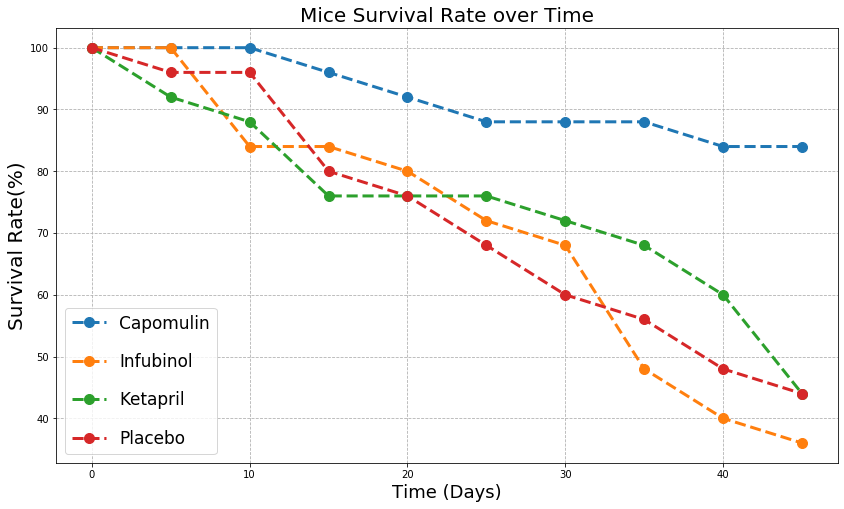

In [587]:
# Generate the Plot (Accounting for percentages) # Save the Figure # Show the Figure

plt.figure(figsize=(14,8))
plt.xlabel('Time (Days)', fontsize=18)
plt.ylabel('Survival Rate(%)', fontsize=20)
plt.title('Mice Survival Rate over Time', fontsize=20)
plt.grid(linestyle='--')


for drug in mouse_percent_df[['Capomulin', 'Infubinol', 'Ketapril', 'Placebo']]:
    plot = plt.errorbar(x=mouse_percent_df.index, y=mouse_percent_df[drug], fmt='o', markersize=10, linestyle='--', linewidth=3, label=drug)
    
plt.legend(loc=0, labelspacing=1.2, fontsize=17)
plt.show()

## Summary Bar Graph

In [588]:
# Calculate the percent changes for each drug # Display the data to confirm

tumor_percent_change = {}

for drug in tumor_response_df.columns:
    tumor_change = ((tumor_response_df[drug].values[-1] - tumor_response_df[drug].values[0]) / tumor_response_df[drug].values[0])*100
    tumor_percent_change[drug] = tumor_change

percent_change_series = pd.Series(tumor_percent_change).rename_axis('Drug') 
percent_change_series

Drug
Capomulin   -19.475303
Ceftamin     42.516492
Infubinol    46.123472
Ketapril     57.028795
Naftisol     53.923347
Placebo      51.297960
Propriva     47.241175
Ramicane    -22.320900
Stelasyn     52.085134
Zoniferol    46.579751
dtype: float64

In [589]:
# Converting the perpercent_change_series into a datframe of required drugs

summary_df = pd.DataFrame(s).loc[['Capomulin', 'Infubinol', 'Ketapril', 'Placebo']].rename(columns={0:'percent'}).reset_index()
summary_df

,Drug,percent
0,Capomulin,-19.475303
1,Infubinol,46.123472
2,Ketapril,57.028795
3,Placebo,51.297960


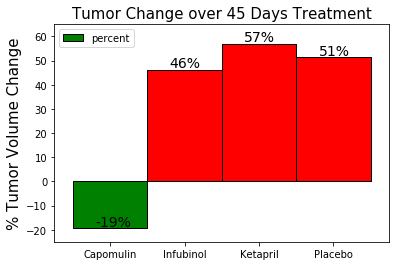

In [555]:
# Store all Relevant Percent Changes into a Tuple
# Splice the data between passing and failing drugs
# Orient widths. Add labels, tick marks, etc. 
# Use functions to label the percentages of changes
# Call functions to implement the function calls
# Save the Figure 
# Show the Figure

color = []
for value in summary_df['percent'].values:
    if value < 0:
        color.append('green')
    else:
        color.append('red')

bars = summary_df.plot(kind='bar', x='Drug', y = 'percent', width=1, color=color, align="center", ec="black")
plt.xticks(rotation=360)
plt.ylim(-25,65)

for bar in bars.patches:
    value = bar.get_height()
    plt.text(bar.get_x()+.3, value+1, f"{value:.0f}%", fontsize=14)
    
plt.xlabel(None)    
plt.ylabel('% Tumor Volume Change', fontsize=15)
plt.title('Tumor Change over 45 Days Treatment', fontsize=15)
plt.legend(loc='upper left')
# plt.figure(figsize=(200,10))
plt.show()

Drug
Capomulin   -19.475303
Ceftamin     42.516492
Infubinol    46.123472
Ketapril     57.028795
Naftisol     53.923347
Placebo      51.297960
Propriva     47.241175
Ramicane    -22.320900
Stelasyn     52.085134
Zoniferol    46.579751
dtype: float64